# Linear Regression

The goal is to handle some missing data in weather data set with linear regression

In [4]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing

### Weather observations
As a first step, implement the method load_weather_data(), which should read all individual (yearly) datasets from the csv files in data/weather/ into a single pd.DataFrame and return it.

In [7]:
data_path = r'H:\projects\ML\MLearnPlayground\data'
weather_data_path = os.path.join(data_path, 'weather')

In [9]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]: 
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    
    def split_columns(data):
        airPressure = []
        skyCover = []
        temp = []
        hum = []
        windDir = []
        windBeauf = []

        for item in data:
            if 'airPressure' in item:
                airPressure.append(item)
            elif 'skyCover' in item:
                skyCover.append(item)
            elif 'temp' in item:
                temp.append(item)
            elif 'hum' in item:
                hum.append(item)
            elif 'windDir' in item:
                windDir.append(item)
            elif 'windBeauf' in item:
                windBeauf.append(item)
        
        return [airPressure, skyCover, temp, hum, windDir, windBeauf]
        

    def melt_df_for_multiple_values(df: pd.DataFrame, id_vars, value_vars_list: list[list[str]], value_names_list: list[str]) -> pd.DataFrame:
        array_of_dfs = []
        i=0
        for i, value_var in enumerate(value_vars_list):
            new_df = pd.melt(df, id_vars=id_vars, var_name='variable', value_vars=value_var, value_name=value_names_list[i])
            new_df = new_df.sort_values(by=[id_vars, 'variable']).reset_index(drop=True)
            new_df = new_df.drop('variable', axis=1)
            if i != 0:
                new_df = new_df.drop(id_vars, axis=1)
            array_of_dfs.append(new_df)
        return pd.concat(array_of_dfs, axis=1)

#=======================================================================
#                     Function Main Code
#=======================================================================

# Load all data
    weather_data_list = []
    for file in os.listdir(weather_data_path):
        if file.endswith('.csv'):
            filePath = os.path.join(weather_data_path, file)
            df = pd.read_csv(filePath, delimiter=';')
            weather_data_list.append(df)

# Prepare full data
    weather_full_data = pd.concat(weather_data_list, ignore_index=True).sort_values(by='date')
    weather_full_data['date'] = pd.to_datetime(weather_full_data['date'], format='%d.%m.%Y')
# Filter data for weather_data
    filtered_weather_data = weather_full_data[[col for col in weather_full_data.columns if (col.endswith('h') or col == 'date')]]
    filtered_weather_data.columns = filtered_weather_data.columns.str.replace('7h', '1').str.replace('14h', '2').str.replace('19h', '3')

# Set up column names for weather_data
    columns = list(filtered_weather_data.columns)
    columns.remove('date')
    columns = split_columns(columns)

# Make wide filtered_weather_data to long weather_data with melt function
    weather_data=melt_df_for_multiple_values(filtered_weather_data, 
                                    'date', 
                                    columns, 
                                    ['airPressure', 'skyCover', 'temp', 'hum', 'windDir', 'windBeauf'])
# Add columns 'hour' 'day' 'month' 'year' for indexing
    weather_data['hour'] = [7,14,19]*int(weather_data['date'].count()/3)
    weather_data['day'] = weather_data['date'].dt.day
    weather_data['month'] = weather_data['date'].dt.month
    weather_data['year'] = weather_data['date'].dt.year
# Set up multiindex
    weather_data=weather_data.set_index(['year','month','day','hour'])

# Filter data for weather_data_daily
    filtered_weather_data_daily = weather_full_data[[col for col in weather_full_data.columns if not col.endswith('h')]]
# Create weather_data_daily
    weather_data_daily = pd.DataFrame(data=filtered_weather_data_daily.sort_values(by='date'))
# Add columns 'day' 'month' 'year' for indexing
    weather_data_daily['day'] = weather_data_daily['date'].dt.day
    weather_data_daily['month'] = weather_data_daily['date'].dt.month
    weather_data_daily['year'] = weather_data_daily['date'].dt.year
# Set up multiindex
    weather_data_daily=weather_data_daily.set_index(['year','month','day'])
    
    return weather_data, weather_data_daily

In [11]:
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     NaN   
               14   2009-01-02        998.5         9  -1.3   66       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2


daily weather data:


date  precip precipType
year month day                              
2009 1     1   2009-01-01       0        NaN
           2   2009-01-02  traces       snow
           3   2009-01-03       0        NaN
           4   2009-01-04  traces       snow
           5   2009-01-05  traces       snow

In [13]:
print(f"Data dimensions are: {weather_data.shape[0]} rows and {weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{weather_data.dtypes}")

print(f"\nFor daily data: \nData dimensions are: {daily_weather_data.shape[0]} rows and {daily_weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{daily_weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{daily_weather_data.dtypes}")

Data dimensions are: 16434 rows and 7 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
hour     int64
dtype: object

column types are: 
-----------------
date           datetime64[ns]
airPressure           float64
skyCover                int64
temp                  float64
hum                     int64
windDir                object
windBeauf               int64
dtype: object

For daily data: 
Data dimensions are: 5478 rows and 3 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
dtype: object

column types are: 
-----------------
date          datetime64[ns]
precip                object
precipType            object
dtype: object


### Handling missing values

#### Visualize some data
Plot temperature (temp) and air pressure (airPressure) as a function of time for the weather data.

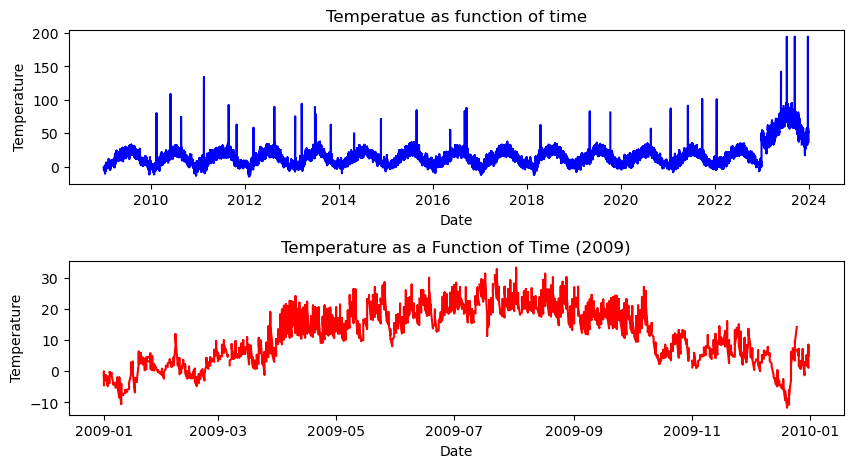

In [17]:
# plot the temperature 
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.title('Temperatue as function of time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.subplots_adjust(hspace=0.5)
plt.plot(weather_data['date'], weather_data['temp'], 'b')

# Just for fun, I'd like to have a closer look in 2009
plt.subplot(2, 1, 2)
data_2009 = weather_data[(weather_data['date'].dt.year == 2009)]
plt.title('Temperature as a Function of Time (2009)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(data_2009['date'], data_2009['temp'], 'r', label='2009')

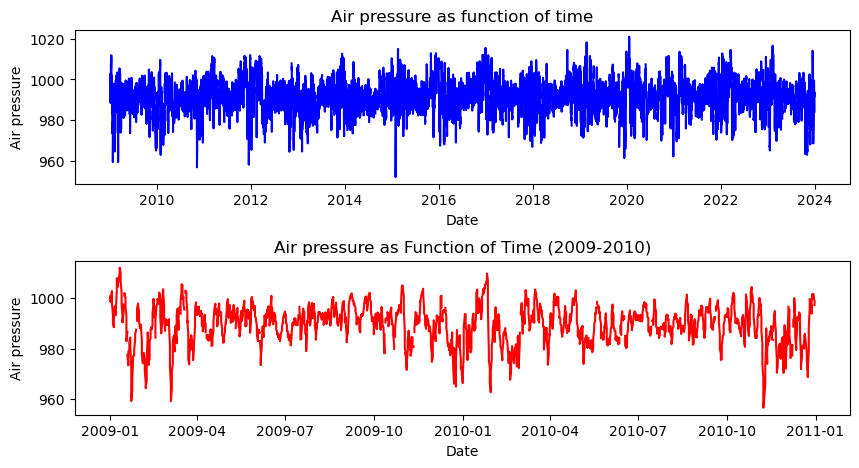

In [20]:
# plot the air pressure 

plt.figure(figsize=(10, 5))

plt.subplot(2,1,1)
plt.title('Air pressure as function of time')
plt.xlabel('Date')
plt.ylabel('Air pressure')
plt.subplots_adjust(hspace=0.5)
plt.plot(weather_data['date'], weather_data['airPressure'],'b')

# Just for fun, I'd like to have a closer look in 2009 and 2010
plt.subplot(2,1,2)
plt.title('Air pressure as Function of Time (2009-2010)')
plt.xlabel('Date')
plt.ylabel('Air pressure')
data_2009_2010 = weather_data[(weather_data['date'].dt.year == 2009) | (weather_data['date'].dt.year == 2010)]
plt.plot(data_2009_2010['date'], data_2009_2010['airPressure'], 'r')

Find and visualize missing values for temp and airPressure columns in the weather_data data frame.

In [23]:
def get_data_around_missing(df:pd.DataFrame, column:str, 
                            delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    import datetime
    
    df_list = []

    missing_rows = df[df[column].isnull()]

    for _, missing_row in missing_rows.iterrows():
        missing_date = missing_row['date']
        start_interval = missing_date - datetime.timedelta(days=delta_days)
        end_interval = missing_date + datetime.timedelta(days=delta_days)
        data = df[(df['date'] >= start_interval) & (df['date'] <= end_interval)].copy()

        df_list.append(data)

    return df_list

In [25]:
missing_temp_df_list = get_data_around_missing(weather_data, 'temp')
missing_airPressure_df_list = get_data_around_missing(weather_data, 'airPressure')
print(len(missing_temp_df_list))
print(len(missing_airPressure_df_list))

336
319
